In [1]:
import keras
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras.models import load_model
import matplotlib.pyplot as plt
#load mnist dataset
(X_train_loaded, y_train_loaded), (X_test_loaded, y_test_loaded) = mnist.load_data()


Using TensorFlow backend.


# Preparing the Dataset

In [54]:
X_train = X_train_loaded.reshape(X_train_loaded.shape[0], 28, 28, 1)
X_test = X_test_loaded.reshape(X_test_loaded.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train/=255
X_test/=255

number_of_classes = 10
y_train = keras.utils.to_categorical(y_train_loaded, num_classes=number_of_classes)
y_test = keras.utils.to_categorical(y_test_loaded, num_classes=number_of_classes)

#decreasing dataset to train faster for algorithm testing
X_train, _,_,_,_,_ = np.split(X_train,6)
y_train, _,_,_,_,_ = np.split(y_train,6)
input_shape = X_train[1].shape
print(input_shape)
print(X_train.shape)

(28, 28, 1)
(10000, 28, 28, 1)


In [158]:
class Network:
    def __init__(self):
        model = Sequential()
        model.add(Convolution2D(24, kernel_size=(3, 3), strides=(1, 1),activation='relu',input_shape=input_shape))
        model.add(Convolution2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(100,activation = "relu"))
        model.add(Dense(10, activation="softmax"))
        model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
        self.model = model
        self.acc_history = []
    
    def return_acc_history(self):
        return self.acc_history
    
    def get_layer_weight(self,i):
        return self.model.layers[i].get_weights()
    
    def set_layer_weight(self,i,weight):
        self.model.layers[i].set_weights(weight)
        
    def train(self):
        self.model.fit(X_train,y_train, batch_size = 32, epochs = 1, verbose = 1,shuffle = True) #, validation_data =(X_test, y_test)
    
    def test(self):
        loss, acc = self.model.evaluate(X_test,y_test)
        self.acc_history.append(acc)
        return acc
    
    def load_layer_weights(self,weights):
        self.model.set_weights(weights) 
    
    def give_weights(self):
        return self.model.get_weights()
    def weight_len(self):
        i = 0 
        for j in self.model.layers:
            i+=1
        return i 
    def architecture(self):
        self.model.summary()

In [170]:
class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, generations = 50):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.population = None
        self.children_population_weights = []
        self.acces = []
        self.norm_acces = []
        
    def create_population(self):
        self.population = [Network() for i in range(self.population_size)]
    
    def train_generation(self):
        for member in self.population:
                member.train()
                
    def predict(self):
        for member in self.population:
                acc = member.test()
                self.acc.append(acc)
                #logging.info("Losses: {}".format(loss))
    
    def normalize(self):
        sum_ = sum(self.acc)
        self.norm_acc = [i/sum_ for i in self.acc] 
        print("\nNormalization sum: ",sum(self.norm_acc))
        #assert sum(self.norm_acc) == 1
        
    def show_weights(self):
        for i in parent_weights:
            print(i)
    def clear_losses(self):
        self.norm_acc = []
        self.acc = []
        
    def mutate(self):
        for member in self.population:
            for i in range(member.weight_len()):
                if np.random.random() < self.mutation_rate:
                    print("\nMutation!")
                    old_weight = member.get_layer_weight(i)
                    new_weight = [np.random.uniform(low=-1, high=1, size=old_weight[i].shape) for i in range(len(old_weight))]
                    member.set_layer_weight(i, new_weight)
    
    def reproduction(self):
        """ 
        Reproduction through midpoint crossover method 
        """
        population_idx = [i for i in range(len(self.population))]
        for i in range(len(self.population)):
        #selects two parents probabilistic accroding to the fitness
            if sum(self.norm_acc) != 0:
                parent1 = np.random.choice(population_idx, p = self.norm_acc)
                parent2 = np.random.choice(population_idx, p = self.norm_acc)
            else:
              # if there are no "best" parents choose randomly 
                parent1 = np.random.choice(population_idx)
                parent2 = np.random.choice(population_idx)

            # picking random midpoint for crossing over name/DNA
            parent1_weights = self.population[parent1].give_weights()
            parent2_weights = self.population[parent2].give_weights()
            
            
            mid_point = np.random.choice([i for i in range(len(parent1_weights))])
            # adding DNA-Sequences of the parents to final DNA
            self.children_population_weights.append(parent1_weights[:mid_point] + parent2_weights[mid_point:])
        # old population gets the new and proper weights
        for i in range(len(self.population)):
            for j in range(len(self.children_population_weights)):
                self.population[i].load_layer_weights(self.children_population_weights[j])
        
        
    
    def run_evolution(self):
        for episode in range(self.generations):
            self.clear_losses()
            self.train_generation()
            self.predict()
            if episode != self.generations -1:
                self.normalize()
                self.reproduction()
                self.mutate()
            else:
                pass
        
        # plotting history:
        for a in range(self.generations):
            for member in self.population:
                plt.plot(member.acc_history)
        plt.xlabel("Generations")
        plt.ylabel("Accuracy")
        plt.show()

Epoch 1/1
10000/10000 [==============================] - 7s - loss: 0.3771 - acc: 0.8849     
Epoch 1/1
10000/10000 [==============================] - 7s - loss: 0.4131 - acc: 0.8746     
Epoch 1/1
10000/10000 [==============================] - 7s - loss: 0.4243 - acc: 0.8704     
Epoch 1/1
 9792/10000 [============================>.] - ETA: 0s
Normalization sum:  1.0
Epoch 1/1
10000/10000 [==============================] - 1s - loss: 0.2247 - acc: 0.9298     
Epoch 1/1
10000/10000 [==============================] - 1s - loss: 0.2359 - acc: 0.9282     
Epoch 1/1
10000/10000 [==============================] - 1s - loss: 0.2324 - acc: 0.9304     
Epoch 1/1
 9856/10000 [============================>.] - ETA: 0s
Normalization sum:  1.0

Mutation!

Mutation!
Epoch 1/1
10000/10000 [==============================] - 1s - loss: 4.5053 - acc: 0.4987     
Epoch 1/1
10000/10000 [==============================] - 1s - loss: 0.1065 - acc: 0.9681     
Epoch 1/1
10000/10000 [=========================

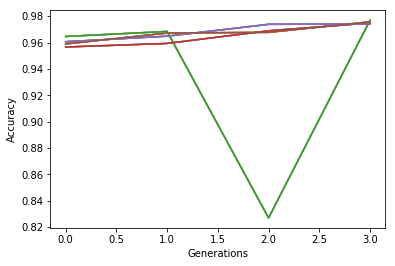

In [173]:
GA = GeneticAlgorithm(population_size = 4,mutation_rate = 0.05, generations = 4)
GA.create_population()
GA.run_evolution()